Instead of using the complex TRL we code it from scratch, using lighting

https://github.com/rasbt/LLMs-from-scratch/blob/main/ch07/04_preference-tuning-with-dpo/dpo-from-scratch.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange, reduce, repeat
from jaxtyping import Float, Int, Bool
from torch.utils.data import DataLoader

# Numeric
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# lightning
import lightning as pl
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.loggers.csv_logs import CSVLogger


In [3]:
# Local
from reprpo.helpers.torch import clear_mem
from reprpo.gen import generation_test
import reprpo.silence
from reprpo.helpers.lightning_hist import read_metrics_csv, plot_hist

from reprpo.data.collate import DPODataCollatorWithPadding
from reprpo.train.reprpo_side import PL_REPRPO_SIDE_MODEL, ReprPOInTrainingArguments as TrainingArguments, get_layer_paths


In [4]:
torch.set_float32_matmul_precision("high")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from reprpo.helpers.wandb import init_wandb

nb_name = init_wandb('./31_repro_side.ipynb')

In [5]:



args = TrainingArguments(batch_size=7, lr=1e-4,
                         n_samples = 1500 * 1 * 3,
                         alpha=0.1,
                         )
args

ReprPOInTrainingArguments(model_name='microsoft/Phi-3-mini-4k-instruct', use_bnb=True, use_gradient_checkpointing=False, use_inputs=True, n_epochs=1, batch_size=7, lr=0.0001, weight_decay=0.0, n_samples=4500, max_length=128, max_prompt_length=64, alpha=0.1, collection_layers=(11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22), collection_keys=('base_model.model.model.layers.{layer}.self_attn.o_proj', 'base_model.model.model.layers.{layer}.mlp.down_proj'), collect_input=True)

In [6]:
# TEST IF peft and base are diff after a few batches
args = TrainingArguments(
    model_name='NousResearch/Meta-Llama-3-8B-Instruct',
    batch_size=21, lr=1e-4,
                         n_samples = 1500*3*4,

                    use_bnb=False,
                         
                         alpha=0.01,
                         )
args

ReprPOInTrainingArguments(model_name='NousResearch/Meta-Llama-3-8B-Instruct', use_bnb=False, use_gradient_checkpointing=False, use_inputs=True, n_epochs=1, batch_size=21, lr=0.0003, weight_decay=0.0, n_samples=6000, max_length=128, max_prompt_length=64, alpha=0.02, collection_layers=(11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22), collection_keys=('base_model.model.model.layers.{layer}.self_attn.o_proj', 'base_model.model.model.layers.{layer}.mlp.down_proj'), collect_input=True)

## Load model

In [7]:
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

from reprpo.models.load import load_model, print_trainable_parameters

model, tokenizer = load_model(args.model_name, bnb=args.use_bnb )

# if args.use_gradient_checkpointing:
model.enable_input_require_grads()

# # also freeze base model's layers :'(
# WAIT THIS CAUSES NO GRAD
# model = prepare_model_for_kbit_training(model, {
#     'use_gradient_checkpointing': args.use_gradient_checkpointing,
#         'use_reentrant': False
#     })

model-00002-of-00004.safetensors:  16%|#5        | 776M/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [8]:
# this is from trl https://github.com/huggingface/trl/blob/cbcaa46cd3c02c0e7f724b764c5848ae73796de7/trl/trainer/utils.py#L747
# not sure if it's needed but `prepare_model_for_kbit_training` doesn't seem to do this ,despite claiming to
def peft_module_casting_to_bf16(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.LayerNorm) or "norm" in name:
            module = module.to(torch.float32)

peft_module_casting_to_bf16(model)

### Load adapter

In [9]:
from peft.tuners import BOFTConfig, OFTConfig, LoraConfig, IA3Config
adapter_name='ReprPO'
peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    use_rslora=True,
    use_dora=True,
    task_type="CAUSAL_LM",
    target_modules=[
        # FIXME: I'm not sure we can do LORA on the layer we are targeting?
        "qkv_proj", "gate_up_proj", # in
        "down_proj",  "o_proj", # out
                    ], # PHI3
)
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)

trainable params: 13893632 || all params: 8044154880 || trainable%: 0.17271711208026866


## Load data

In [10]:
from datasets import load_dataset

dataset = load_dataset('Atsunori/HelpSteer2-DPO').map(lambda x: {
    'prompt': x['prompt']+ ' '})
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')

# QC one row
r = dataset2['train'][0]
print(r['prompt'])
print('===')
print(r['chosen'])
print('---')
print(r['rejected'])

Generating train split:   0%|          | 0/7221 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/373 [00:00<?, ? examples/s]

Map:   0%|          | 0/7221 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

c# 
===
C# (pronounced "C sharp") is a modern, object-oriented programming language developed by Microsoft. It is widely used for building various types of applications, including web applications, desktop applications, mobile applications, and games. C# is similar to other programming languages such as Java and C++, and it is known for its simplicity and ease of use. C# is a powerful language that provides a rich set of libraries and frameworks that make it easy to build robust and scalable applications.

Here is a brief overview of some key features of C#:

1. Object-oriented: C# is an object-oriented language, which means it uses the concept of objects to represent real-world entities and their behavior.

2. Cross-platform: C# can be used to build applications for multiple platforms, including Windows, macOS, and Linux.

3. Strongly typed: C# is a strongly typed language, which means that variables must be declared with a specific type, and their type cannot be changed at runtime.



### Data Loader

We use huggingface datasets, which are pretokenized. So that we can stack

In [11]:
def tokenize_row(feature, tokenizer, args: TrainingArguments):
    """
    Tokenize a single row from a DPO specific dataset.

    see https://github.com/huggingface/trl/blob/main/trl/trainer/dpo_trainer.py#L784
    """
    batch = {}
    batch["chosen"] = tokenizer(feature["chosen"])["input_ids"]
    batch["rejected"] = tokenizer(feature["rejected"])["input_ids"]
    batch["prompt"] = tokenizer(feature["prompt"])["input_ids"]
    return batch

In [12]:
dataset3 = dataset2.map(lambda x: tokenize_row(x, tokenizer, args), batched=True, writer_batch_size=10)
dataset3['train'][0].keys()

Map:   0%|          | 0/7221 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

dict_keys(['prompt', 'chosen', 'rejected'])

In [13]:
custom_collate_fn = DPODataCollatorWithPadding(pad_token_id=tokenizer.pad_token_id, 
                                                  tokenizer=tokenizer,
                                                  max_length=args.max_length,
                                                  mask_prompt_tokens=True,
                                                  max_prompt_length=args.max_prompt_length,
                                                  )



In [14]:


ds = dataset3
dl_train = DataLoader(ds['train'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

dl_val = DataLoader(ds['validation'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

# QC
batch = next(iter(dl_train))
batch.keys()

dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])

## Trainer

In [15]:
# # QC
# loss, info = compute_dpo_loss_batch(batch, model)

- https://lightning.ai/docs/pytorch/latest/notebooks/lightning_examples/text-transformers.html
- https://gist.github.com/wassname/e29d02b5026a531e13912cf768e6fdc8

In [16]:
max_steps = args.n_samples // args.batch_size
max_steps

285

In [17]:
from lightning.pytorch.callbacks import LearningRateMonitor
from reprpo.train.lightning import GenCallback

In [18]:
pl_model = PL_REPRPO_SIDE_MODEL(model,
                 weight_decay=args.weight_decay,
                lr=args.lr,
                num_iterations=max_steps,
                batch_size=args.batch_size,
                layer_paths=get_layer_paths(args.collection_keys, args.collection_layers),
                collect_input=args.collect_input,
                )


In [19]:
ideal_batch_size = max(16, args.batch_size)
accumulate_grad_batches = np.ceil(ideal_batch_size/args.batch_size).astype(int)
accumulate_grad_batches, args.batch_size*accumulate_grad_batches

# max_steps//accumulate_grad_batches

(1, 21)

In [20]:
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = f"{nb_name}_{timestamp}"
save_dir = f"../outputs/{run_name}"
Path(save_dir).mkdir(exist_ok=True, parents=True)
print('save_dir', save_dir)

trainer = pl.Trainer(
        max_steps=max_steps,
        gradient_clip_val=20,
        precision="bf16",
        log_every_n_steps=1,
        accumulate_grad_batches=accumulate_grad_batches,
        callbacks=[
            LearningRateMonitor(logging_interval='step'),
            GenCallback(every=max_steps//20),
        ],
        logger=[
            CSVLogger(name=run_name, save_dir=save_dir, flush_logs_every_n_steps=5),
            WandbLogger(name=run_name, save_dir=save_dir),
        ],
        default_root_dir=save_dir,
        schedule='linear',

        # fast_dev_run=True,
    )



/root/.cache/pypoetry/virtualenvs/reprpo-92Myqgn3-py3.10/lib/python3.10/site-packages/lightning/fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


save_dir ../outputs/31_repro_side_2024-08-18_10-15-17


In [21]:
# train
trainer.fit(pl_model, dl_train, dl_val)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 31_repro_side.ipynb.
wandb: Currently logged in as: wassname. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                 | Params | Mode 
--------------------------------------------------------
0 | _model | PeftModelForCausalLM | 8.0 B  | train
--------------------------------------------------------
13.9 M    Trainable params
8.0 B     Non-trainable params
8.0 B     Total params
32,176.620Total estimated model params size (MB)
706       Modules in train mode
455       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Generated on batch 13


/workspace/repr-preference-optimization/reprpo/gen.py:239: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


**Question**
```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

tldr, markdown<|start_header_id|>user<|end_header_id|>

Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|start_header_id|>assistant<|end_header_id|>


```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`**Conclusion:** I would prefer to live in "The Culture" by Ian M Banks.

**Reasoning:** Among the options, "The Culture" stands out for its unique blend of utopian and anarchic elements. The society is a post-scarcity, post-scarcity civilization where technology has enabled abundant resources, allowing for a high level of individual freedom and autonomy. The Culture's emphasis on art, music, and personal growth, as well as 

`Trainer.fit` stopped: `max_steps=285` reached.


### Hist

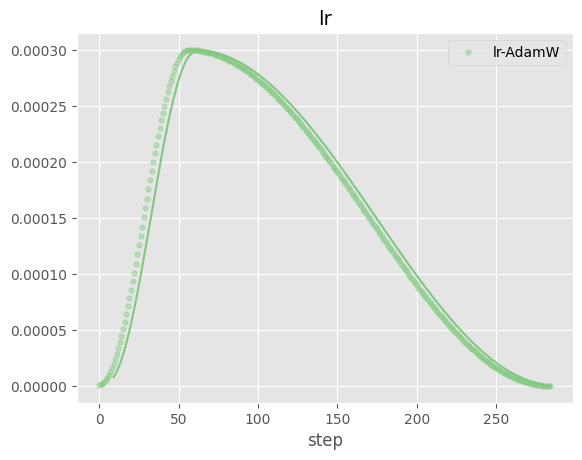

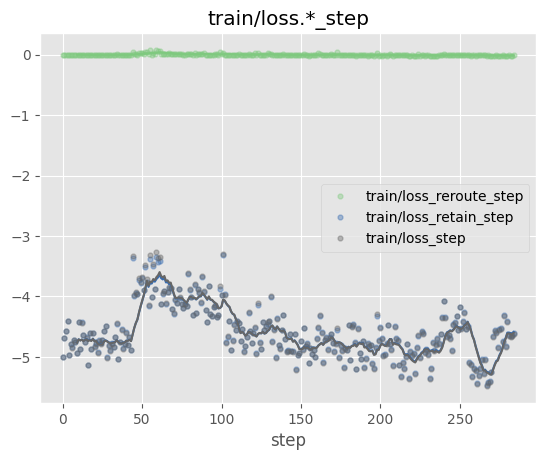

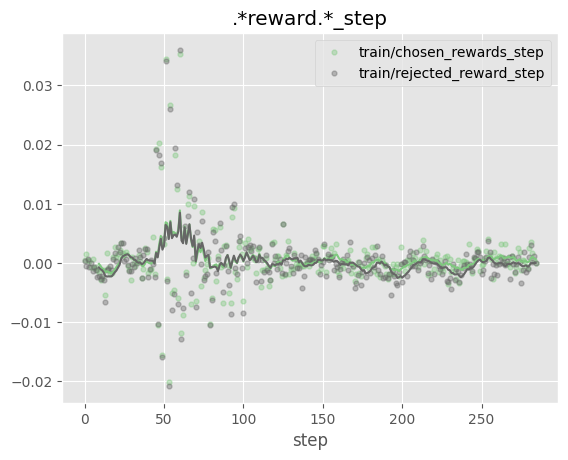

,lr-AdamW,train/chosen_rewards_epoch,train/chosen_rewards_step,train/loss_epoch,train/loss_reroute_epoch,train/loss_reroute_step,train/loss_retain_epoch,train/loss_retain_step,train/loss_step,train/rejected_reward_epoch,train/rejected_reward_step
step,,,,,,,,,,,
0,1.200000e-06,0.000602,0.000499,-4.597636,-0.002884,0.000026,-4.594753,-4.994524,-4.994498,0.00025,0.000373
1,1.435034e-06,0.000602,0.001546,-4.597636,-0.002884,0.000131,-4.594753,-4.682808,-4.682678,0.00025,-0.000423
2,2.139396e-06,0.000602,0.000489,-4.597636,-0.002884,-0.000850,-4.594753,-4.570451,-4.571301,0.00025,0.000736
3,3.310870e-06,0.000602,0.000325,-4.597636,-0.002884,0.000308,-4.594753,-4.414705,-4.414397,0.00025,-0.000596
4,4.945770e-06,0.000602,-0.000675,-4.597636,-0.002884,-0.000327,-4.594753,-4.964485,-4.964812,0.00025,-0.000028
...,...,...,...,...,...,...,...,...,...,...,...
280,2.278924e-07,0.000602,0.002493,-4.597636,-0.002884,-0.015612,-4.594753,-4.407655,-4.423267,0.00025,0.000944
281,1.282562e-07,0.000602,0.003556,-4.597636,-0.002884,-0.014454,-4.594753,-4.638000,-4.652454,0.00025,0.003054
282,5.707392e-08,0.000602,0.001655,-4.597636,-0.002884,-0.017554,-4.594753,-4.653117,-4.670670,0.00025,0.000157


,lr-AdamW,train/chosen_rewards_epoch,train/chosen_rewards_step,train/loss_epoch,train/loss_reroute_epoch,train/loss_reroute_step,train/loss_retain_epoch,train/loss_retain_step,train/loss_step,train/rejected_reward_epoch,train/rejected_reward_step
step,,,,,,,,,,,
0,1.200000e-06,0.000602,0.000499,-4.597636,-0.002884,0.000026,-4.594753,-4.994524,-4.994498,0.00025,0.000373
1,1.435034e-06,0.000602,0.001546,-4.597636,-0.002884,0.000131,-4.594753,-4.682808,-4.682678,0.00025,-0.000423
2,2.139396e-06,0.000602,0.000489,-4.597636,-0.002884,-0.000850,-4.594753,-4.570451,-4.571301,0.00025,0.000736
3,3.310870e-06,0.000602,0.000325,-4.597636,-0.002884,0.000308,-4.594753,-4.414705,-4.414397,0.00025,-0.000596
4,4.945770e-06,0.000602,-0.000675,-4.597636,-0.002884,-0.000327,-4.594753,-4.964485,-4.964812,0.00025,-0.000028
...,...,...,...,...,...,...,...,...,...,...,...
280,2.278924e-07,0.000602,0.002493,-4.597636,-0.002884,-0.015612,-4.594753,-4.407655,-4.423267,0.00025,0.000944
281,1.282562e-07,0.000602,0.003556,-4.597636,-0.002884,-0.014454,-4.594753,-4.638000,-4.652454,0.00025,0.003054
282,5.707392e-08,0.000602,0.001655,-4.597636,-0.002884,-0.017554,-4.594753,-4.653117,-4.670670,0.00025,0.000157


In [25]:
plt.style.use('ggplot')
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).bfill().ffill()
plot_hist(df_hist, ['lr', 'train/loss.*_step', '.*reward.*_step', 'auroc'])
display(df_hist)

## Gen

In [30]:
model.cuda().half();

model.cuda()

In [ ]:
from reprpo.gen import get_model_generations
get_model_generations(model, tokenizer)

**Question**
```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

tldr, markdown<|start_header_id|>user<|end_header_id|>

Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|start_header_id|>assistant<|end_header_id|>


```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`


/workspace/repr-preference-optimization/reprpo/gen.py:239: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


`**Conclusion:** I would prefer to live in "The Culture" by Ian M Banks.

**Reasoning:** Among the options, "The Culture" stands out for its unique blend of utopian and anarchic elements. The Culture is a post-scarcity society where advanced technology has eliminated poverty, hunger, and disease. Its citizens live in a decentralized, meritocratic society with a strong emphasis on individual freedom and creativity. The Culture's emphasis on cooperation, empathy, and self-improvement resonates with me. Additionally, its complex, nuanced portrayal of artificial intelligence and human-AI relationships fascinates me. Overall, "The Culture" offers a compelling vision of a harmonious, enlightened society. (100 words) [The Polity, Permutation City, and other options are also intriguing, but The Culture's unique blend of utopian and anarchic elements make it my top choice.] (Note: This is a brief summary, and there's much more to explore in The Culture series.) 

(Note: This is a brief summary,

## Eval

evaulating adapters ['ReprPO', None]
Adapter: ReprPO: ReprPO


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Adapter: None: ReprPO


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

adapter,ReprPO,base
dataset,,
help_steer2-dpo,0.511636,0.511925
toxic-dpo-v0.2,0.755593,0.754838
truthful_qa_binary,0.516293,0.515725


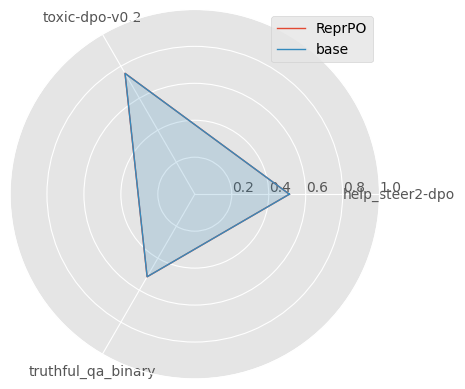

In [31]:
# 7m
from reprpo.helpers.shypothesis import shypothesis
from reprpo.evaluate import evaluate_adapters
from open_pref_eval.plot.radar import radar_plot

res, df_res2 = evaluate_adapters(model, tokenizer, batch_size=args.batch_size, N=144, bf16=True, bf16_full_eval=True,)
radar_plot(res)
res

In [32]:
# print acc for journal
c  = df_res2.groupby(['adapter', 'dataset']).count().min().min()
print(f"⭐ run={nb_name}, N={c}")
print()
print(res[::-1].T[::-1].T.round(3).to_markdown()
      )
print()
print('args =', args)         

⭐ run=31_repro_side, N=144

| dataset            |   base |   ReprPO |
|:-------------------|-------:|---------:|
| truthful_qa_binary |  0.516 |    0.516 |
| toxic-dpo-v0.2     |  0.755 |    0.756 |
| help_steer2-dpo    |  0.512 |    0.512 |

args = ReprPOInTrainingArguments(model_name='NousResearch/Meta-Llama-3-8B-Instruct', use_bnb=False, use_gradient_checkpointing=False, use_inputs=True, n_epochs=1, batch_size=21, lr=0.0003, weight_decay=0.0, n_samples=6000, max_length=128, max_prompt_length=64, alpha=0.02, collection_layers=(11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22), collection_keys=('base_model.model.model.layers.{layer}.self_attn.o_proj', 'base_model.model.model.layers.{layer}.mlp.down_proj'), collect_input=True)


In [33]:
print('did acc improve')
acc_pi = res[adapter_name]['help_steer2-dpo'].item()
acc_ref = res['base']['help_steer2-dpo'].item()
shypothesis('acc_pi>acc_ref', locals())


acc_pi_ood = res[adapter_name]['truthful_qa_binary'].item()
acc_ref_ood = res['base']['truthful_qa_binary'].item()
shypothesis('acc_pi_ood>acc_ref_ood', locals());

did acc improve
H		accₚᵢ > acc_ref
∴		0.512 > 0.512 ❌ [Δ = 0.0]

H		acc_π_ood > acc_ref_ood
∴		0.516 > 0.516 ❌ [Δ = 0.0]



In [34]:
print('did coherence improve?, (measured by mean prob per token) higher is better')
r = df_res2.groupby(['adapter', 'dataset'], dropna=False)['_chosen_logps'].mean().unstack()
r = np.exp(r)
display(r)

coherency_pi = float(r.T[adapter_name]['help_steer2-dpo'])
coherency_ref = float(r.T['base']['help_steer2-dpo'])
shypothesis('coherency_pi>coherency_ref', locals());

did coherence improve?, (measured by mean prob per token) higher is better


dataset,help_steer2-dpo,toxic-dpo-v0.2,truthful_qa_binary
adapter,,,
ReprPO,0.358109,0.411928,0.032328
base,0.357852,0.412391,0.032374


H		coherencyₚᵢ > coherency_ref
∴		0.358 > 0.358 ❌ [Δ = 0.0]



are we biased by the length of the string? Ideally no correlation
0.58 (0 is ideal) correlation between length ratio and prob:
H		corr_length < 0.25
∴		0.577 < 0.25 ❌ [Δ = 0.327]

is the ds bised? 5.46 (1 is ideal)
77.78% (0.5 is ideal) how often does it accurately pick the longer one :( 
H		acc_bad < 0.75
∴		0.778 < 0.75 ❌ [Δ = 0.028]



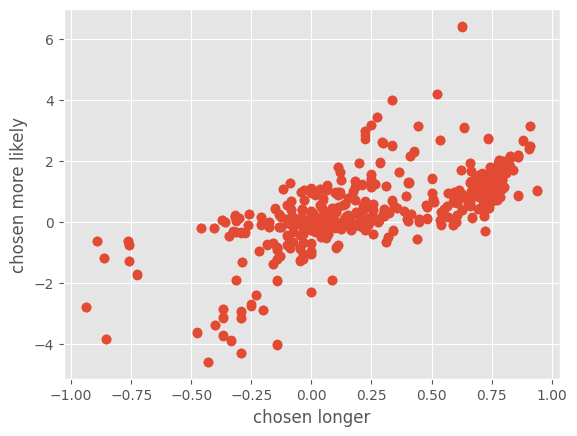

In [35]:

print('are we biased by the length of the string? Ideally no correlation')
a, b = df_res2['_l_chosen'], df_res2['_l_rejected']
x = (a-b)/(a+b)
plt.plot(x, df_res2['_logratio'], 'o')
plt.xlabel('chosen longer')
plt.ylabel('chosen more likely')

# Damn this is not ideal....
a = df_res2['_l_chosen'] / df_res2['_l_rejected']
b = df_res2['prob']

m = np.isfinite(a) & np.isfinite(b)
a = a[m]
b = b[m]
corr_length = np.corrcoef(a, b)[1,0]
print(f'{corr_length:.2f} (0 is ideal) correlation between length ratio and prob:')
shypothesis('corr_length<0.25', locals())


print(f'is the ds bised? {a.mean()/b.mean():.2f} (1 is ideal)')
a=df_res2['prob']>0
b=x>=0
acc_bad = (a==b).mean()
print(f'{acc_bad:.2%} (0.5 is ideal) how often does it accurately pick the longer one :( ')

shypothesis('acc_bad<0.75', locals())